In [1]:
#Sentiment-Analyse und Sentiment-Modellierung für Amazon-Bewertungen

#Kozmos, ein Unternehmen, das Heimtextilien und Alltagsbekleidung herstellt und über Amazon verkauft, möchte seine Verkäufe steigern, indem es die Bewertungen seiner Produkte analysiert und die Eigenschaften entsprechend den eingegangenen Beschwerden verbessert.
#Zu diesem Zweck werden die Rezensionen einer Sentiment-Analyse unterzogen und entsprechend gekennzeichnet. Mit den gekennzeichneten Daten soll anschließend ein Klassifikationsmodell erstellt werden.

#Der Datensatz besteht aus Bewertungen zu einer bestimmten Produktgruppe und enthält folgende Variablen:

#Review: Die abgegebene Produktbewertung

#Title: Der kurze Titel der Bewertung

#HelpFul: Anzahl der Personen, die die Bewertung als hilfreich empfunden haben

#Star: Vergebene Sternebewertung für das Produkt

In [2]:
# Basisbibliotheken
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from warnings import filterwarnings

# NLP-Bibliotheken
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import Word, TextBlob
from wordcloud import WordCloud

# Machine-Learning-Bibliotheken
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer  
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer

# --- Allgemeine Einstellungen ---
filterwarnings("ignore")

pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: f"{x:.2f}")
pd.set_option("display.width", 200)


In [3]:
df = pd.read_excel(r"C:\Users\nesri\repos\AmozonReviewsNLP\amazon.xlsx")
df.head()

,Star,HelpFul,Title,Review
0,5,0,looks great,Happy with it
1,5,0,Pattern did not align between the two panels.,Good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,Product was fun for bedroom windows.<br />Imag...
3,5,0,Que se ven elegantes muy finas,Lo unico que me gustaria es que sean un poco ...
4,5,0,Wow great purchase,Great bang for the buck I can't believe the qu...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5611 entries, 0 to 5610
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Star     5611 non-null   int64 
 1   HelpFul  5611 non-null   int64 
 2   Title    5559 non-null   object
 3   Review   5593 non-null   object
dtypes: int64(2), object(2)
memory usage: 175.5+ KB


In [5]:
df.isnull().sum()

Star        0
HelpFul     0
Title      52
Review     18
dtype: int64

In [6]:
# Alle NaN-Werte durch leere Strings ("") ersetzen
df = df.fillna("")

In [7]:
df.isnull().sum()

Star       0
HelpFul    0
Title      0
Review     0
dtype: int64

In [8]:
# AUFGABE 1: Textvorverarbeitung
           #Schritt 1: Lesen Sie die Datei amazon.xlsx ein.
           #Schritt 2: Auf der Variablen "Review" die folgenden Vorverarbeitungsschritte anwenden:
            # a. Alle Buchstaben in Kleinbuchstaben umwandeln
            # b. Satzzeichen entfernen
            # c. In den Rezensionen vorkommende Zahlen entfernen
            # d. Stoppwörter (nicht informative Wörter) aus den Daten entfernen
            # e. Wörter, die weniger als 1000-mal vorkommen, aus den Daten entfernen
            # f. Lemmatisierung anwenden

In [9]:
# Alle Buchstaben in Kleinbuchstaben umwandeln
df['Review'] = df['Review'].str.lower()
df['Review'].head()

0                                        happy with it
1    good quality material however the panels are m...
2    product was fun for bedroom windows.<br />imag...
3     lo unico que me gustaria es que sean un poco ...
4    great bang for the buck i can't believe the qu...
Name: Review, dtype: object

In [10]:
# Satzzeichen entfernen
df['Review'] = df['Review'].str.replace(r"[^\w\s]", " ", regex=True)
df['Review'] = df['Review'].str.replace(r"\s+", " ", regex=True).str.strip()
df['Review'].head()

0                                        happy with it
1    good quality material however the panels are m...
2    product was fun for bedroom windows br imagery...
3    lo unico que me gustaria es que sean un poco m...
4    great bang for the buck i can t believe the qu...
Name: Review, dtype: object

In [11]:
# In den Rezensionen vorkommende Zahlen entfernen
df['Review'] = df['Review'].str.replace('\d', '', regex=True)
df['Review'].head()

0                                        happy with it
1    good quality material however the panels are m...
2    product was fun for bedroom windows br imagery...
3    lo unico que me gustaria es que sean un poco m...
4    great bang for the buck i can t believe the qu...
Name: Review, dtype: object

In [12]:
# Stoppwörter (nicht informative Wörter) aus den Daten entfernen
sw = stopwords.words('english')
df['Review'] = df['Review'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))
df['Review'].head()

0                                                happy
1     good quality material however panels mis matched
2    product fun bedroom windows br imagery bit str...
3    lo unico que gustaria es que sean un poco mas ...
4    great bang buck believe quality material vibra...
Name: Review, dtype: object

In [13]:
# Wörter, die weniger als 1000-mal vorkommen, aus den Daten entfernen
all_words  = pd.Series(' '.join(df['Review']).split()).value_counts()
rare_words = pd.Series(' '.join(df['Review']).split()).value_counts()[-1000:]

print(f"{len(rare_words)} seltene Wörter gefunden (weniger als 1000-mal).\n")

print(f"Insgesamt {len(all_words)} verschiedene Wörter gefunden.\n")


1000 seltene Wörter gefunden (weniger als 1000-mal).

Insgesamt 5801 verschiedene Wörter gefunden.



In [14]:
rare_words

córners       1
drawback      1
west          1
amaizin       1
coke          1
             ..
elephant      1
relatively    1
wfh           1
gamers        1
cobbles       1
Name: count, Length: 1000, dtype: int64

In [15]:
df['Review'] = df['Review'].apply(lambda x: " ".join(x for x in x.split() if x not in rare_words))
df['Review'].head() 

0                                                happy
1     good quality material however panels mis matched
2    product fun bedroom windows br imagery bit str...
3    lo unico que gustaria es que sean un poco mas ...
4    great bang buck believe quality material vibra...
Name: Review, dtype: object

In [16]:
all_words  = pd.Series(' '.join(df['Review']).split()).value_counts()
print(f"Insgesamt {len(all_words)} verschiedene Wörter gefunden.\n")

Insgesamt 4801 verschiedene Wörter gefunden.



In [17]:
# Lemmatisierung anwenden
df['Review'] = df['Review'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df['Review'].head()

0                                                happy
1       good quality material however panel mi matched
2    product fun bedroom window br imagery bit stre...
3    lo unico que gustaria e que sean un poco ma la...
4    great bang buck believe quality material vibra...
Name: Review, dtype: object

In [18]:
# AUFGABE 2: Textvisualisierung
# Balkendiagramm
# Schritt 1: Erstellung des Balkendiagramms
        # a. Berechnen Sie die Häufigkeit der Wörter in der Variable "Review" und speichern Sie diese als tf
        # b. Benennen Sie die Spalten des tf-DataFrames um: "words", "tf"
        # c. Filtern Sie die Daten nach Wörtern, deren "tf"-Wert größer als 500 ist, und visualisieren Sie diese mit einem Balkendiagramm

In [19]:
#Berechnen Sie die Häufigkeit der Wörter in der Variable "Review" und speichern Sie diese als tf
tf = df["Review"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
#Benennen Sie die Spalten des tf-DataFrames um: "words", "tf"
tf.columns = ["words", "tf"]
tf = tf.sort_values("tf", ascending=False) 
tf.head()

,words,tf
53,curtain,2630.00
42,look,1548.00
121,love,1475.00
89,room,1155.00
164,like,1066.00


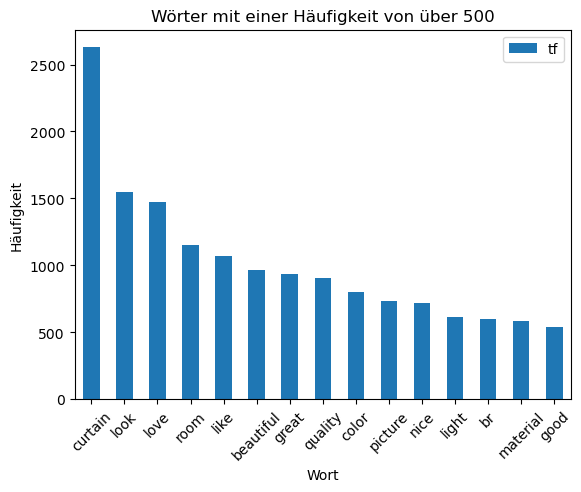

In [20]:
# Filtern Sie die Daten nach Wörtern, deren "tf"-Wert größer als 500 ist, und visualisieren Sie diese mit einem Balkendiagramm
tf[tf["tf"] > 500].plot.bar(x="words", y="tf")
# Titel und Achsenbeschriftungen
plt.title("Wörter mit einer Häufigkeit von über 500", fontsize=12)
plt.xlabel("Wort")
plt.ylabel("Häufigkeit")
plt.xticks(rotation=45)
plt.show()

In [21]:
# WordCloud
# Schritt 2: Erstellung der WordCloud-Visualisierung
        # a. Speichern Sie alle Wörter der Variablen "Review" als String unter dem Namen "text"
        # b. Legen Sie mithilfe von WordCloud Ihre Vorlagenform fest und speichern Sie diese
        # c. Generieren Sie die gespeicherte WordCloud mit dem im ersten Schritt erstellten String
        # d. Schließen Sie die Visualisierungsschritte ab (figure, imshow, axis, show)

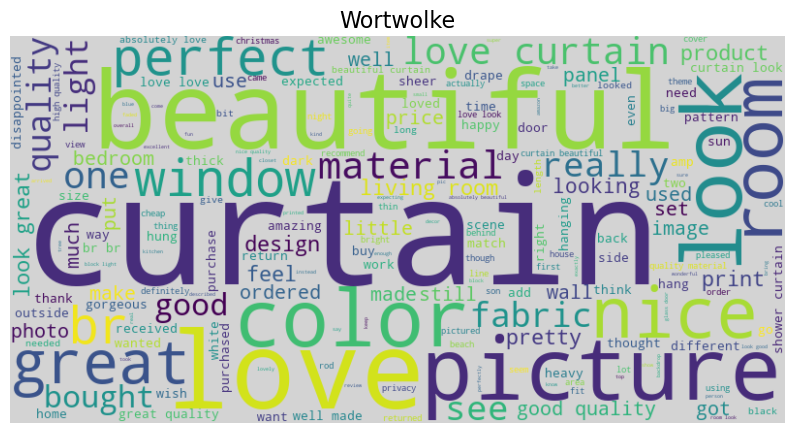

In [22]:
# Speichern Sie alle Wörter der Variablen "Review" als String unter dem Namen "text"
text = " ".join(i for i in df.Review)

# WordCloud erstellen
wordcloud = WordCloud(width=800, height=400, background_color="lightgrey").generate(text)

# Visualisierung
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Wortwolke", fontsize=16)
plt.show()

In [23]:
# AUFGABE 3: Sentiment-Analyse
# Schritt 1: Erstellen Sie ein SentimentIntensityAnalyzer-Objekt aus dem in Python enthaltenen NLTK-Paket
# Schritt 2: Untersuchung der Polaritätswerte mit dem SentimentIntensityAnalyzer
             # a. Berechnen Sie polarity_scores() für die ersten 10 Beobachtungen der Variablen "Review"
             # b. Filtern Sie die ersten 10 Beobachtungen anhand ihrer Compound-Scores und betrachten Sie sie erneut
             # c. Aktualisieren Sie die 10 Beobachtungen: Wenn der Compound-Score größer als 0 ist, dann "pos", ansonsten "neg"
             # d. Weisen Sie für alle Beobachtungen der Variablen "Review" ein pos/neg-Label zu und fügen Sie dieses als neue Variable dem DataFrame hinzu

# HINWEIS: Durch die Etikettierung der Kommentare mit dem SentimentIntensityAnalyzer wurde eine abhängige Variable
# für das Klassifikationsmodell des maschinellen Lernens erstellt.


In [24]:
# Erstellen Sie ein SentimentIntensityAnalyzer-Objekt aus dem in Python enthaltenen NLTK-Paket
sia = SentimentIntensityAnalyzer()

In [25]:
# Berechnen Sie polarity_scores() für die ersten 10 Beobachtungen der Variablen "Review"
df["Review"][0:10].apply(lambda x: sia.polarity_scores(x))

0    {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...
1    {'neg': 0.0, 'neu': 0.674, 'pos': 0.326, 'comp...
2    {'neg': 0.0, 'neu': 0.563, 'pos': 0.437, 'comp...
3    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
4    {'neg': 0.0, 'neu': 0.495, 'pos': 0.505, 'comp...
5    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
6    {'neg': 0.0, 'neu': 0.631, 'pos': 0.369, 'comp...
7    {'neg': 0.0, 'neu': 0.578, 'pos': 0.422, 'comp...
8    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
9    {'neg': 0.0, 'neu': 0.772, 'pos': 0.228, 'comp...
Name: Review, dtype: object

In [26]:
# Filtern Sie die ersten 10 Beobachtungen anhand ihrer Compound-Scores und betrachten Sie sie erneut
df["Review"][0:10].apply(lambda x: sia.polarity_scores(x)["compound"])

0   0.57
1   0.44
2   0.85
3   0.00
4   0.90
5   0.00
6   0.62
7   0.91
8   0.00
9   0.71
Name: Review, dtype: float64

In [27]:
# Aktualisieren Sie die 10 Beobachtungen: Wenn der Compound-Score größer als 0 ist, dann "pos", ansonsten "neg"
df["Review"][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

0    pos
1    pos
2    pos
3    neg
4    pos
5    neg
6    pos
7    pos
8    neg
9    pos
Name: Review, dtype: object

In [28]:
# Weisen Sie für alle Beobachtungen der Variablen "Review" ein pos/neg-Label zu und fügen Sie dieses als neue Variable dem DataFrame hinzu
df["Sentiment_Label"] = df["Review"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")
df["Sentiment_Label"].head()

0    pos
1    pos
2    pos
3    neg
4    pos
Name: Sentiment_Label, dtype: object

In [29]:
df.groupby("Sentiment_Label")["Star"].mean()

Sentiment_Label
neg   3.40
pos   4.57
Name: Star, dtype: float64

In [30]:
# AUFGABE 4: Vorbereitung für das maschinelle Lernen.
# Schritt 1: Bestimmen Sie die abhängigen und unabhängigen Variablen und teilen Sie die Daten in Train- und Test-Sets auf.
# Schritt 2: Damit wir die Daten an das Machine-Learning-Modell übergeben können, müssen die Repräsentationen in numerische Werte umgewandelt werden.
           # a. Erstellen Sie ein Objekt mit TfidfVectorizer.
           # b. Führen Sie ein Fit mit dem zuvor aufgeteilten Trainingsdatensatz auf dem erstellten Objekt durch.
           # c. Wenden Sie die Transform-Funktion des erstellten Vektors auf die Train- und Test-Daten an und speichern Sie die Ergebnisse.

In [31]:
# Bestimmen Sie die abhängigen und unabhängigen Variablen und teilen Sie die Daten in Train- und Test-Sets auf.
train_x, test_x, train_y, test_y = train_test_split(df["Review"],df["Sentiment_Label"],test_size=0.2,random_state=42)

In [32]:
# Erstellen Sie ein Objekt mit TfidfVectorizer.
tf_idf_word_vectorizer = TfidfVectorizer().fit(train_x)
# Führen Sie ein Fit mit dem zuvor aufgeteilten Trainingsdatensatz auf dem erstellten Objekt durch.
x_train_tf_idf_word = tf_idf_word_vectorizer.transform(train_x)
# Wenden Sie die Transform-Funktion des erstellten Vektors auf die Train- und Test-Daten an und speichern Sie die Ergebnisse.
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(test_x)

In [33]:
# Größe der Trainings- und Test-Matrizen
print("Größe von x_train_tf_idf_word:", x_train_tf_idf_word.shape)
print("Größe von x_test_tf_idf_word :", x_test_tf_idf_word.shape)

# Anzahl der verschiedenen Wörter (Merkmale)
print("Anzahl der Merkmale (Wörter):", x_train_tf_idf_word.shape[1])

Größe von x_train_tf_idf_word: (4488, 3936)
Größe von x_test_tf_idf_word : (1123, 3936)
Anzahl der Merkmale (Wörter): 3936


In [34]:
# AUFGABE 5: Modellierung (Logistische Regression)
# Schritt 1: Erstellen Sie ein logistische Regressionsmodell und fitten Sie es mit den Trainingsdaten.
# Schritt 2: Führen Sie Vorhersagen mit dem erstellten Modell durch.
        # a. Verwenden Sie die Predict-Funktion, um die Testdaten vorherzusagen und zu speichern.
        # b. Verwenden Sie classification_report, um die Vorhersageergebnisse zu berichten und zu analysieren.
        # c. Verwenden Sie die cross_val_score-Funktion, um den durchschnittlichen Genauigkeitswert (Accuracy) zu berechnen.


In [35]:
# Erstellen Sie ein logistische Regressionsmodell und fitten Sie es mit den Trainingsdaten.
log_model = LogisticRegression().fit(x_train_tf_idf_word, train_y)
# Verwenden Sie die Predict-Funktion, um die Testdaten vorherzusagen und zu speichern.
y_pred = log_model.predict(x_test_tf_idf_word)
# Verwenden Sie classification_report, um die Vorhersageergebnisse zu berichten und zu analysieren.
print(classification_report(y_pred, test_y))

              precision    recall  f1-score   support

         neg       0.31      0.98      0.47        55
         pos       1.00      0.89      0.94      1068

    accuracy                           0.89      1123
   macro avg       0.66      0.94      0.71      1123
weighted avg       0.97      0.89      0.92      1123



In [36]:
# Verwenden Sie die cross_val_score-Funktion, um den durchschnittlichen Genauigkeitswert (Accuracy) zu berechnen.
log_cv_accuracy = cross_val_score(log_model, x_test_tf_idf_word, test_y, cv=5).mean()
print("Durchschnittliche Genauigkeit des Logistik-Regression-Modells (CV):", log_cv_accuracy)

Durchschnittliche Genauigkeit des Logistik-Regression-Modells (CV): 0.8486190476190476


In [37]:
# Schritt 3: Zufällige Auswahl von Kommentaren aus den Daten, um sie dem Modell zu übergeben.
        # a. Verwenden Sie die sample-Funktion, um eine Stichprobe aus der Variable "Review" zu ziehen und einer neuen Variable zuzuweisen.
        # b. Vektorisieren Sie die erhaltene Stichprobe mit CountVectorizer, damit das Modell sie verarbeiten kann.
        # c. Wenden Sie fit- und transform-Funktionen auf die vektorisierte Stichprobe an und speichern Sie das Ergebnis.
        # d. Geben Sie die Stichprobe dem erstellten Modell, um die Vorhersage zu erhalten, und speichern Sie das Ergebnis.
        # e. Geben Sie die Stichprobe und das Vorhersageergebnis auf dem Bildschirm aus.

In [38]:
# Verwenden Sie die sample-Funktion, um eine Stichprobe aus der Variable "Review" zu ziehen und einer neuen Variable zuzuweisen.
random_review = pd.Series(df["Review"].sample(1).values)  

In [39]:
# Vektorisieren Sie die erhaltene Stichprobe mit CountVectorizer, damit das Modell sie verarbeiten kann.
vectorizer = CountVectorizer()
# Wenden Sie fit- und transform-Funktionen auf die vektorisierte Stichprobe an und speichern Sie das Ergebnis.
vectorizer.fit(train_x)                 
new_review = vectorizer.transform(random_review)

In [40]:
#Geben Sie die Stichprobe dem erstellten Modell, um die Vorhersage zu erhalten, und speichern Sie das Ergebnis.
prediction = log_model.predict(new_review)
# Geben Sie die Stichprobe und das Vorhersageergebnis auf dem Bildschirm aus.
print("Ausgewählter Kommentar:")
print(random_review.values[0])
print("\nVorhersage des Modells:")
print(prediction[0])

Ausgewählter Kommentar:
cute closet curtain daughter love

Vorhersage des Modells:
pos


In [41]:
# AUFGABE 6: Modellierung (Random Forest)
# SCHRITT 1: Random Forest Modell erstellen und Vorhersageergebnisse untersuchen
         # a. Erstellen Sie ein RandomForestClassifier-Modell und fitten Sie es.
         # b. Berechnen Sie den durchschnittlichen Accuracy-Wert mit der Cross-Validation-Funktion.
         # c. Vergleichen Sie die Ergebnisse mit dem Logistic Regression Modell.

In [42]:
# Erstellen Sie ein RandomForestClassifier-Modell und fitten Sie es.
rf_model = RandomForestClassifier(random_state=42).fit(x_train_tf_idf_word, train_y)

In [43]:
# Berechnen Sie den durchschnittlichen Genauigkeitswert (Accuracy) mit der Cross-Validation-Funktion.
rf_cv_accuracy = cross_val_score(rf_model, x_test_tf_idf_word, test_y, cv=5, n_jobs=-1).mean()
print("Durchschnittliche Genauigkeit des Random Forest Modells (CV):", rf_cv_accuracy)

Durchschnittliche Genauigkeit des Random Forest Modells (CV): 0.89225


In [44]:
# Vergleichen Sie die Ergebnisse mit dem Logistic-Regression-Modell.
if rf_cv_accuracy > log_cv_accuracy:
    print("Das Random-Forest-Modell erzielte eine höhere Genauigkeit.")
else:
    print("Das Logistic-Regression-Modell erzielte eine höhere Genauigkeit.")

Das Random-Forest-Modell erzielte eine höhere Genauigkeit.
